In [1]:
from IPython import display
from scipy.io import wavfile
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt

In [2]:
display.Audio(url='data/cocktailparty.wav')

In [3]:
Fs, data = wavfile.read('data/cocktailparty.wav')
print('Frekvencija uzorkovanja: ', Fs)
print('Uzorci: ', data.shape)

Frekvencija uzorkovanja:  44100
Uzorci:  (363200,)


In [4]:
N = data.shape[0]
duration = N / Fs
n = 256

In [5]:
window = np.hanning(n)
window.shape

(256,)

In [14]:
hopsamp = 64

In [55]:
def stft(data):
    spectrogram = np.zeros((N-n, n),dtype=np.complex_)
    for i in range(0, N-n):
        samples = data[i : i+n ]
        c = fft.fft(samples*window) 
        spectrogram[i, :] = c
    return spectrogram

In [50]:
def istft(spectrogram):
    x = np.zeros(N)
    for i in range(0, N-n):
        x[i : i+n] += window * np.real(fft.ifft(spectrogram[i]))
    return x

In [80]:
magnitude_spectrogram = np.abs(stft(data))
x_reconstructed = np.zeros(N)
iterations = 10
reconstruction_spectrogram = stft(x_reconstructed)
prev_reconstruction_angle = np.angle(reconstruction_spectrogram)
proposal_spectrogram = magnitude_spectrogram*np.exp(1.0j*prev_reconstruction_angle)
prev_x = x_reconstructed
x_reconstructed = istft(proposal_spectrogram)
rmse_history = []
rmse = np.sqrt(sum((x_reconstructed - prev_x)**2)/x_reconstructed.size)
ssnr_history = []
# e = np.sqrt(np.sum((np.abs(reconstruction_spectrogram)-magnitude_spectrogram)**2))
e = np.linalg.norm(np.abs(reconstruction_spectrogram)-magnitude_spectrogram, ord=2)
print(e)
# e /= np.sqrt(np.sum((magnitude_spectrogram)**2))
e /= np.linalg.norm(magnitude_spectrogram, ord = 2)
print(e)
ssnr = -10 * np.log10(e)
print('Reconstruction iteration: {}/{} - RMSE: {} - SSNR: {}'.format(0, iterations, rmse, ssnr))
rmse_history.append(rmse)
ssnr_history.append(ssnr)
for i in range(iterations):
    reconstruction_spectrogram = stft(x_reconstructed)
    reconstruction_angle = np.angle(reconstruction_spectrogram)
    # potencijalno treba umesto prethodnog ugla da se cuva prethodni spektrogram
    reconstruction_angle += 0.99 * (reconstruction_angle - prev_reconstruction_angle)
    prev_reconstruction_angle = reconstruction_angle
    proposal_spectrogram = magnitude_spectrogram*np.exp(1.0j*reconstruction_angle)
    prev_x = x_reconstructed
    x_reconstructed = istft(proposal_spectrogram)
    rmse = np.sqrt(sum((x_reconstructed - prev_x)**2)/x_reconstructed.size)
#     e = np.sqrt(np.sum((np.abs(reconstruction_spectrogram)-magnitude_spectrogram)**2))
    e = np.linalg.norm(np.abs(reconstruction_spectrogram)-magnitude_spectrogram, ord=2)
    print(e)
#     e /= np.sqrt(np.sum((magnitude_spectrogram)**2))
    e /= np.linalg.norm(magnitude_spectrogram, ord = 2)
    print(e)
    ssnr = -10 * np.log10(e)
    print('Reconstruction iteration: {}/{} - RMSE: {} - SSNR: {}'.format(0, iterations, rmse, ssnr))
    rmse_history.append(rmse)
    ssnr_history.append(ssnr)

254206838.89754334
1.0
Reconstruction iteration: 0/10 - RMSE: 44483.64556846942 - SSNR: -0.0
4004553554.885366
15.753130687799391
Reconstruction iteration: 0/10 - RMSE: 122204.13042795043 - SSNR: -11.973668759239224
11026809892.87669


KeyboardInterrupt: 

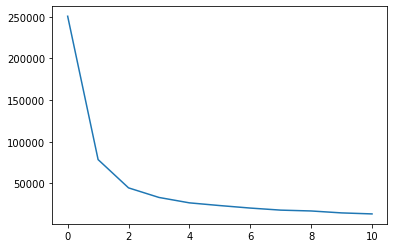

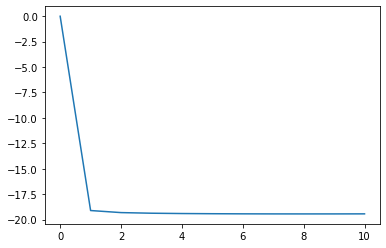

In [74]:
plt.plot(rmse_history)
plt.show()
plt.plot(ssnr_history)
plt.show()

In [41]:
# plt.imshow(np.flip(np.log(np.abs(stft(data)))).T, aspect='auto')
# plt.colorbar()
# plt.show()

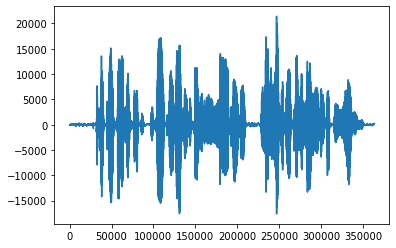

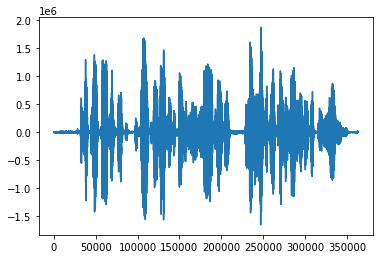

In [67]:
plt.plot(data)
plt.show()
plt.plot(x_reconstructed)
plt.show()

In [68]:
display.Audio(data=x_reconstructed, rate=Fs)